# Final Project - MNIST Image Classification
This notebook validates the full image classification pipeline developed for the final project.
It demonstrates all major steps of the solution, including data ingestion, preprocessing,
model training, and evaluation.

All functionality shown in this notebook relies on the modular Python code implemented
in the project repository. The purpose of the notebook is to provide an executable and
reproducible validation of the complete system.

## Task - Image Reconition
I have chosen the image recognition task for this final project

### Environment and Setup
This section verifies the execution environment used for validation.
The project is implemented in PyTorch and supports both CPU and GPU execution.
If a CUDA-enabled GPU is available, it will be used automatically during training
and evaluation.

In [1]:
import sys
from pathlib import Path
import torch
import os

ROOT = Path.cwd().parent
cdir = os.chdir(ROOT)

print(ROOT)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 980 Ti


### Data Ingestion
The MNIST dataset is not stored directly in the repository.
Instead, a dedicated ingestion step is used to download and prepare the dataset
in a reproducible manner.

This approach ensures that the repository remains lightweight and that the dataset
can be recreated on any machine by executing the ingestion step.

In [2]:
from steps.ingest import download_mnist
data_dir = ROOT / "data"
download_mnist(data_dir=str(data_dir))
data_dir

PosixPath('/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/data')

### Dataset Inspection and Sanity Checks
Before training, the dataset is inspected to verify its basic properties.
This includes checking the number of samples in the training and test sets,
the image resolution, and the available class labels.

These checks help confirm that the dataset is correctly loaded and matches
the expected MNIST specification.

In [3]:
from torchvision import datasets

train_raw = datasets.MNIST(root=str(data_dir), train=True, download=False)
test_raw = datasets.MNIST(root=str(data_dir), train=False, download=False)

print("Train samples:", len(train_raw))
print("Test samples:", len(test_raw))
print("Image size:", train_raw[0][0].size)
print("Unique labels:", sorted(set(train_raw.targets.tolist())))

Train samples: 60000
Test samples: 10000
Image size: (28, 28)
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Preprocessing and Augmentation
The data preprocessing pipeline consists of two conceptually different steps:

1. **Data transformation**, which converts raw images into normalized tensors
   suitable for neural network training.
2. **Data augmentation**, which introduces controlled randomness during training
   to improve model generalization.

Augmentation is applied only to the training data, while the test data uses
deterministic preprocessing to preserve evaluation integrity.

In [4]:
from steps.transform import get_transforms

train_tf = get_transforms(train=True)
test_tf = get_transforms(train=False)

train_tf, test_tf

(Compose(
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ToTensor()
     Normalize(mean=(0.1307,), std=(0.3081,))
 ),
 Compose(
     ToTensor()
     Normalize(mean=(0.1307,), std=(0.3081,))
 ))

### Visual Validation of Augmentation
To verify that data augmentation is applied correctly, the same training image
is passed through the preprocessing pipeline multiple times.
Due to the stochastic nature of the augmentation step, each output may differ
slightly while preserving the original label.

This visual inspection confirms that augmentation is active and functioning as intended.

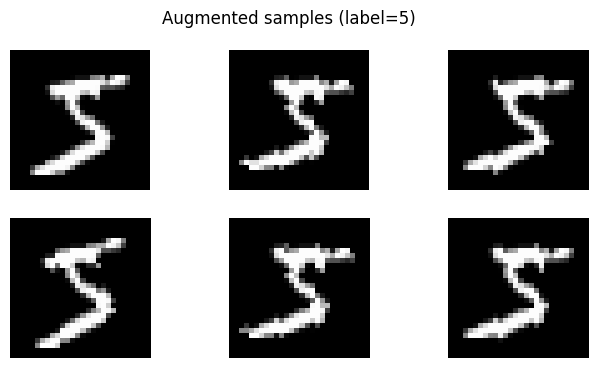

In [5]:
import matplotlib.pyplot as plt

imgs = [train_tf(train_raw[0][0]) for _ in range(6)]
label = train_raw[0][1]

plt.figure(figsize=(8,4))
for i, img in enumerate(imgs):
    plt.subplot(2,3,i+1)
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.axis("off")
plt.suptitle(f"Augmented samples (label={label})")
plt.show()

### DataLoaders and Batch Shapes

The dataset is loaded using PyTorch DataLoaders, which enable efficient batching
and shuffling during training.

In this step, a single batch is inspected to verify:
- the batch size
- the tensor shape of the input images
- the corresponding label tensor shape

The batch dimension (B) represents the number of images processed simultaneously.

In [6]:
from src.data import get_dataloaders

train_loader, test_loader = get_dataloaders(
    data_dir=str(data_dir),
    batch_size=64,
    num_workers=0,
)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


### Model Instantiation and Forward Pass

The convolutional neural network (CNN) used for this project is instantiated
and evaluated on a sample batch.

A forward pass is performed to verify that:
- the model accepts inputs with the expected shape
- the output consists of logits for the 10 MNIST classes

This step confirms that the model architecture is correctly defined.

In [7]:
from src.model import MNISTCNN

model = MNISTCNN()
logits = model(images)

print("Model output shape:", logits.shape)

Model output shape: torch.Size([64, 10])


### Training Procedure
The model is trained using the predefined training pipeline.
For validation purposes, the number of epochs is kept small to ensure
reasonable execution time within the notebook.

The full training procedure, including loss computation and parameter updates,
is implemented in the modular training step and reused here without modification.

In [8]:
from steps.train import train

weights_path = train(
    data_dir=str(data_dir),
    artifacts_dir=str(ROOT / "artifacts"),
    epochs=10,
    batch_size=64,
    lr=1e-3,
    num_workers=2,
)
weights_path

Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 63.01it/s, acc=0.9958, loss=0.0130]


PosixPath('/mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/artifacts/mnist_cnn.pt')

### Evaluation and Metrics

After training, the model is evaluated on the test dataset.
The evaluation step computes standard classification metrics, including:

- Accuracy
- Macro-averaged precision
- Macro-averaged recall

In addition, a confusion matrix is generated to provide a more detailed
view of the model’s classification behavior across all digit classes.

In [9]:
from steps.evaluate import evaluate

artifacts_dir = ROOT / "artifacts"
metrics_path = evaluate(
    data_dir=str(ROOT / "data"),
    artifacts_dir=str(artifacts_dir),
    weights_path=str(artifacts_dir / "mnist_cnn.pt"),
    batch_size=128,
    num_workers=0,
)
print("Metrics saved to:", metrics_path)

Metrics saved to: /mnt/c/Users/jarla/Documents/DVAE26/DVAE26_final_project/artifacts/metrics.json


### Results Visualization
The computed evaluation metrics are loaded and displayed in structured form.
The confusion matrix is visualized to highlight class-specific performance
and potential misclassification patterns.

In [10]:
import json
from PIL import Image

with open(metrics_path) as f:
    metrics = json.load(f)

metrics

{'test_accuracy': 0.991100013256073,
 'test_macro_precision': 0.9910899109367481,
 'test_macro_recall': 0.9910316878524672,
 'test_macro_f1': 0.9910523478833918,
 'example_count': 10000}

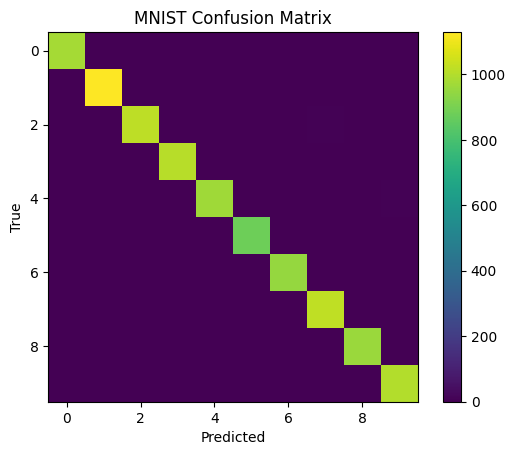

In [11]:
from PIL import Image

Image.open(artifacts_dir / "confusion_matrix.png")

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

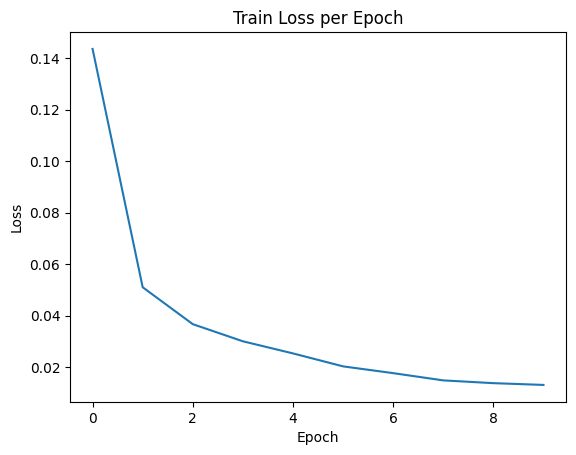

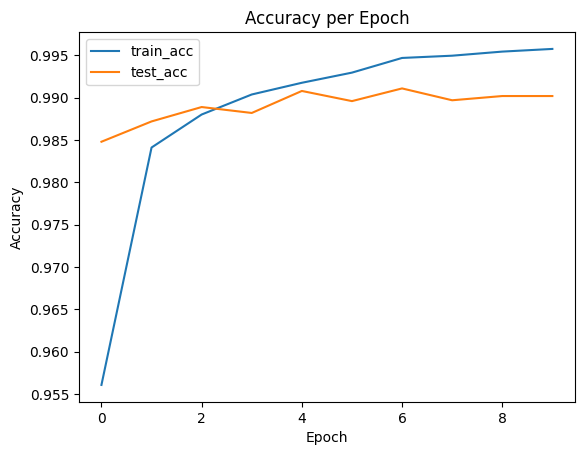

In [12]:
from src.plotting import plot_training_history

hist = json.loads(Path(ROOT / "artifacts" / "train_history.json").read_text(encoding="utf-8"))
plot_training_history(hist["history"], out_dir=ROOT / "artifacts")

In [13]:
print("Best epoch:", hist["best_epoch"])
print("Best test acc:", hist["best_test_acc"])
print("Best test loss:", hist["best_test_loss"])
print("Config:", hist["config"])

Best epoch: 7
Best test acc: 0.9911
Best test loss: 0.027266555276641156
Config: {'epochs': 10, 'batch_size': 64, 'lr': 0.001, 'num_workers': 2, 'seed': 42}


### Validation Summary
This notebook has validated the complete MNIST image classification pipeline.
All stages of the system, from data ingestion to evaluation, were executed successfully.

Key aspects such as dataset sizes, tensor shapes, model interfaces, and evaluation
metrics were explicitly verified, providing confidence in the correctness and
reproducibility of the implemented solution.

## Deployment To Hugging Face

### Login to Hugging Face

In [14]:
#!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()
#checkout git
#login to huggingface, setting, access token, generate a new token

### Preparation for Upload

In [15]:
from pathlib import Path
import shutil

HF_DIR = Path("hf_model")
HF_DIR.mkdir(exist_ok=True)

# Copy trained weights
shutil.copy("artifacts/mnist_cnn.pt", HF_DIR / "mnist_cnn.pt")

# Copy model architecture
shutil.copy("src/model.py", HF_DIR / "model.py")

PosixPath('hf_model/model.py')

### Upload

In [16]:
from huggingface_hub import HfApi

USERNAME = "Vagabond98"
REPO_ID = f"{USERNAME}/dvae26-final-project"

api = HfApi()

api.create_repo(
    repo_id=REPO_ID,
    repo_type="model",
    exist_ok=True,
    private=False,
)

api.upload_folder(
    repo_id=REPO_ID,
    folder_path="hf_model",
    repo_type="model",
)

print("Uploaded to:", f"https://huggingface.co/{REPO_ID}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploaded to: https://huggingface.co/Vagabond98/dvae26-final-project
